I have chosen to forecast the Bitcoin price in GBP as the financial time series. Bitcoin is a fascinating topic for time series analysis since it is a highly volatile and popular cryptocurrency that has grown in importance within the financial ecosystem. My choice is influenced by the asset's robust response to a variety of market and macroeconomic factors as well as my own personal interests. The sharp increase in 2017, the institutional adoption boom in 2020–2021, and the decline in 2022–2023 brought on by interest rate hikes and the failure of significant cryptocurrency firms are just a few of the noteworthy trends and turning points that Bitcoin has seen over the years.

The price of Bitcoin is influenced by several factors. Trading volume, daily transaction volume, market volatility, macroeconomic indicators like inflation and interest rates, and technical metrics like hash rate are all observable and accessible variables. Furthermore, predictive modeling frequently makes use of historical price based indicators like moving averages and lagged returns. Significant unobservable or challenging-to-quantify elements do exist, though, including investor sentiment, speculative activity, geopolitical news, regulatory uncertainty, and the actions of major market participants . These unseen forces have the potential to produce abrupt market swings that quantitative models don't always account for. This step lays the groundwork for developing a realistic and reliable forecasting model by recognizing both the observable and intangible elements.

In [13]:
# 📦 Imports

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# 📥 Step 1: Load Data
df = yf.download("BTC-GBP", start="2020-01-01", end="2024-12-31")
df = df[['Close']].dropna()
df.rename(columns={'Close': 'price'}, inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,price
Ticker,BTC-GBP
Date,
2020-01-01,5433.849121
2020-01-02,5313.357910
2020-01-03,5615.142090
2020-01-04,5665.424805
2020-01-05,5666.796875


In [9]:
#Check for Stationarity
result = adfuller(df['price'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Difference if not stationary
if result[1] > 0.05:
    df['price_diff'] = df['price'].diff()
    df.dropna(inplace=True)
else:
    df['price_diff'] = df['price']


ADF Statistic: -0.5276982204645237
p-value: 0.8864971040835192


[*********************100%***********************]  1 of 1 completed


Optimal alpha: 0.7393755158297789
Optimal L1 ratio: 1.0
Selected Coefficients:
 Price           Ticker
lag1                     -282.747786
lag2                     -271.381710
lag3                      671.861974
lag4                       -9.473665
lag5                       -5.868526
rolling_mean_3            426.172575
rolling_mean_5              0.000000
rolling_std_3              -0.000000
rolling_std_5              -0.000000
exp_moving_avg             68.343276
momentum                  981.529994
dtype: float64
MSE: 42.63502249756333


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.503e+05, tolerance: 1.789e+05
  model = cd_fast.enet_coordinate_descent(


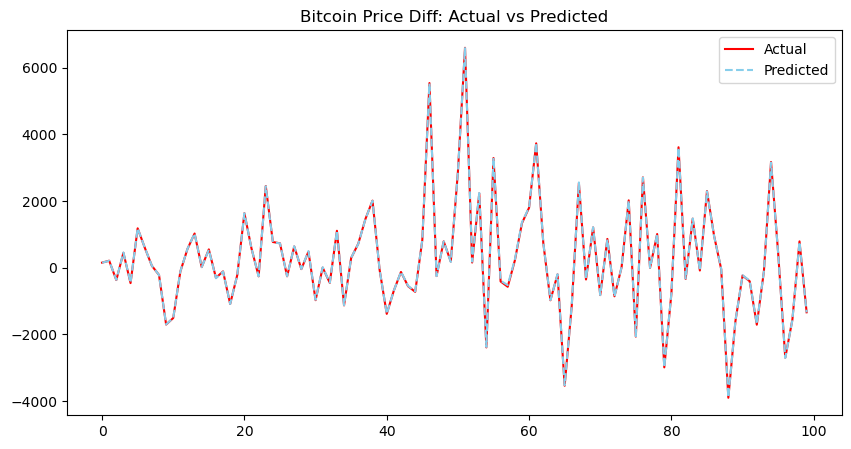

Optimal alpha: 0.7393755158297789
Optimal L1 ratio: 1.0


In [11]:
# Load Data
df = yf.download("BTC-GBP", start="2020-01-01", end="2024-12-31")
df = df[['Close']].dropna()
df.rename(columns={'Close': 'price'}, inplace=True)

# Check for Stationarity
result = adfuller(df['price'])
if result[1] > 0.05:
    df['price_diff'] = df['price'].diff()
else:
    df['price_diff'] = df['price']

# Feature Engineering (>10 features)
df['lag1'] = df['price_diff'].shift(1)
df['lag2'] = df['price_diff'].shift(2)
df['lag3'] = df['price_diff'].shift(3)
df['lag4'] = df['price_diff'].shift(4)
df['lag5'] = df['price_diff'].shift(5)
df['rolling_mean_3'] = df['price_diff'].rolling(3).mean()
df['rolling_mean_5'] = df['price_diff'].rolling(5).mean()
df['rolling_std_3'] = df['price_diff'].rolling(3).std()
df['rolling_std_5'] = df['price_diff'].rolling(5).std()
df['exp_moving_avg'] = df['price_diff'].ewm(span=5, adjust=False).mean()
df['momentum'] = df['price_diff'] - df['price_diff'].shift(3)

# Drop all NaNs just once here
df.dropna(inplace=True)

# Define Target and Features
X = df.drop(columns=['price', 'price_diff'])
y = df['price_diff']

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

 #Time Series Split + ElasticNetCV
tscv = TimeSeriesSplit(n_splits=5)
model = ElasticNetCV(cv=tscv, l1_ratio=[.1, .5, .7, .9, 0.95, 1], random_state=42)
model.fit(X_scaled, y)

# Results
print("Optimal alpha:", model.alpha_)
print("Optimal L1 ratio:", model.l1_ratio_)
print("Selected Coefficients:\n", pd.Series(model.coef_, index=X.columns))

# Predict and Plot
y_pred = model.predict(X_scaled)
mse = mean_squared_error(y, y_pred)
print("MSE:", mse)

plt.figure(figsize=(10,5))
plt.plot(y.values[-100:], label='Actual', color='red')
plt.plot(y_pred[-100:], label='Predicted', color='skyblue', linestyle='--')
plt.title("Bitcoin Price Diff: Actual vs Predicted")
plt.legend()
plt.show()

print("Optimal alpha:", model.alpha_)
print("Optimal L1 ratio:", model.l1_ratio_)

In [12]:
from sklearn.linear_model import ElasticNetCV

model = ElasticNetCV(
    cv=tscv,
    l1_ratio=[.1, .5, .7, .9, 0.95, 1],  # Controls mix of L1 and L2
    random_state=42
)

print(model)

ElasticNetCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1], random_state=42)
